# Neurophysiology and Biophysics - Practical course 2022/23

Cornelia Kopp-Scheinpflug, Kay Thurley


__Miniproject: Gap junctions__


In this notebook we investigate the emergence of oscillations in neurons coupled by gap junctions. For the simulations we use a model of rat hippocampal CA1 neuron and include axo-axonal electrical coupling (gap junctions).

We use the model by Vladimirov et al. 2012 published on ModelDB. Converted to Python by Kay Thurley (2022).


_Requirements:_ You will need Neuron 8, Python 3 and the packages Matplotlib for plotting and Numpy for mathematical functions and array handling.


We start by importing the relevant packages.

In [1]:
# import Neuron's hoc interpreter
from neuron import h
h.load_file('stdrun.hoc')

# set default units
from neuron.units import ms, mV

import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

Then we define the model neuron by loading a morphology file and files with the relevant mechanisms.

In [2]:
# load the morphology and cell biophysics
h.load_file('cellTemplate.hoc')
h.load_file('gapjunction.hoc')
# h.load_file('init_2cells.hoc')

# create pyramidal neurons
dc_bias = -0.1
ncells = 9
cells = h.List()
for i in range(ncells):
    cell = h.pyramidal()
    
    # set position of the cell
    x = 1000.*np.cos(2*np.pi*i/ncells)
    y = 1000.*np.sin(2*np.pi*i/ncells)
    cell.position(x, y, 0)
    cell.setgid(i)
    
    # add constant current to soma
    # current is in nA, "-" for hyperpolarizing, "+" for depolarizing
    area_soma = np.pi*cell.soma.diam*cell.soma.L*1e-8
    cell.soma.insert('bias')
    cell.soma(0.5).bias.amp = -dc_bias * 1e-6/area_soma
    
    # set all conductances to 0 except HH: fast Na+ and K+(DR)
    # used to have only Na(F) and K(DR) conductances and a minimum loop length (9)
    # a model with Na(F), K(DR), K(A) and K(M) requires a loop of 40 cells
    for sec in cell.axonal:
        sec.gbar_ka = 0
        sec.gbar_km = 0
    
    cells.append(cell)

# simulation paramters
h.tstop = 25
h.dt = 0.025
h.v_init = -67

Add gap junctions.

In [3]:
gj_conductance = 0.003 # [mS]
weakgj_conductance = 0.0013 # [mS]

# position of gj in axonal sections:
axonal_section = 21   # section index
section_pos1 = 0.45   # position within section1
section_pos2 = 0.55   # position within section2

gaps = h.List()
for i in range(ncells):
    gap = h.gapjunction(cells[i], axonal_section, cells[(i+1)%ncells], axonal_section, 
                        gj_conductance, section_pos1, section_pos2)
    gap.setcells(i,(i+1)%ncells)
    gaps.append(gap)
    
gaps[0].setg(weakgj_conductance)

0.0

To check, how the compartments are named, call `h('forall print secname()')` or use `h.topology()` for a bit more insight into the morphological structure of the neuron(s).

In [4]:
# h('forall print secname()')
# h.topology()

Let's plot the morphology.

In [5]:
# ps = h.PlotShape(True)

# # get matplotlib plotshape with default coloring (for v)
# ps = h.PlotShape(False).plot(plt)

# # highlight the apical dendrite
# ps._do_plot(0, 1, h.dend, None, color='red')

Add the stimulation.

In [6]:
num_pulses = 1
inter_stim_interval = 5

stim = h.List()
for i in range(num_pulses):
    stim.append(h.IClamp(0.5, sec=cells[0].soma))
    stim[i].amp = 1
    stim[i].delay = 5 + inter_stim_interval * i
    stim[i].dur = 1

Recording settings.

In [7]:
# vectors to store data
t_vec = h.Vector()                  # Time stamp vector
t_vec.record(h._ref_t)

v_pyrA = h.Vector()                 # membrane potential vector for first pyramidal cell
v_pyrB = h.Vector()                 # membrane potential vector for second pyramidal cell


# v_pyrA.record(pyrA.soma(0.5)._ref_v)
# v_pyrB.record(pyrB.soma(0.5)._ref_v)
v_pyrA.record(cells[0].axon[axonal_section](section_pos1)._ref_v)
v_pyrB.record(cells[1].axon[axonal_section](section_pos2)._ref_v)
# note that the voltage is recorded in the axon

# record stimuli
istim = h.List()
for i in range(0, num_pulses):
    istim.append(h.Vector())
    istim[i].record(stim[i]._ref_i)

Let's run the simulation.

In [8]:
h.init()
print('running simulation ...')
h.run()

running simulation ...


0.0

Plot the results.

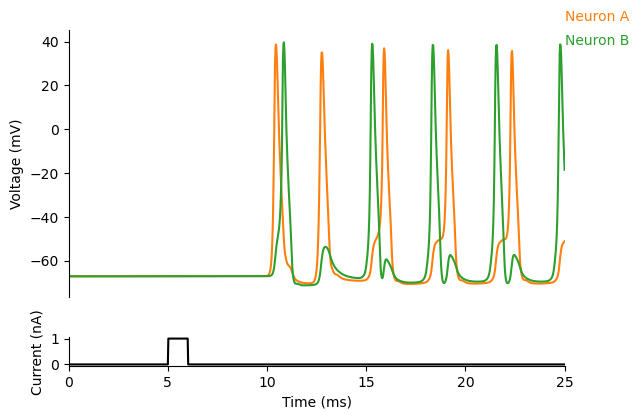

In [9]:
fig = plt.figure()
gs = gridspec.GridSpec(11, 2)

# voltage axis
ax1 = fig.add_subplot(gs[0:8, :])
ax1.plot(t_vec, v_pyrA, '-', color='C01')
ax1.plot(t_vec, v_pyrB, '-', color='C02')
max_v = max(v_pyrA.max(), v_pyrB.max())
fig.text(.9, .9, "Neuron A", color='C01')
fig.text(.9, .85, "Neuron B", color='C02')
ax1.set_ylabel('Voltage ('+h.units('v')+')')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim([0, h.tstop])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# current axis
ax2 = fig.add_subplot(gs[9:10, :], sharex=ax1)
for i in range(num_pulses):
    ax2.plot(t_vec, istim[i], '-', color='k')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Current (nA)')
ax2.set_xlabel('Time ('+h.units('t')+')')
ax2.set_xlim([0, h.tstop])

plt.show()